# Network Analysis Project - Group K

# Research question:

#### How do different subreddit themes affect the underlying community structures in the Reddit hyperlink network?

### Network explanation:

#### Reddit is a forum-like website with many different small forums called subreddits. Users can post content on these subreddits and other users can comment on the content. In the network we are analysing, the nodes are sudreddits and the edges are hyperlinks from comments made by the users from one subreddit to another. So, a usercomment on a post on subreddit *a* with a hyperlink to subreddit *b* correlates to an edge from node *a* to node *b* in the network. Each comment is given a weight of either -1 or +1, that represent if the text in the comment is positve or negative. If the comment is neutral the weight is also 1. The text analysis is done by SNAP at Stanford University.

In [18]:
import community as cd
from collections import Counter, defaultdict
import igraph as ig
import itertools
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)
matplotlib.rcParams.update({'font.size': 18})
plt.style.use('ggplot')
from operator import itemgetter
import pandas as pd
import powerlaw
import random
import seaborn as sns
import warnings

# Ignore two specific warning messages from the powerlaw package. 
# Comment these lines to show warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")

## Data cleaning

In [19]:
# Loading the data in and removing unused columns
# reddit.tsv downloaded from https://snap.stanford.edu/data/soc-redditHyperlinks-body.tsv
G_reddit = pd.read_csv('reddit.tsv', delimiter="\t")
temp = G_reddit.drop(labels=["POST_ID","TIMESTAMP","PROPERTIES"], axis=1)
new = temp.groupby(by=["SOURCE_SUBREDDIT","TARGET_SUBREDDIT"]).sum()
new.to_csv("dataframe.csv")

# Setting edge weights to either positive or negative, according to whether there are mostly positive or mostly negative links
df = pd.read_csv('dataframe.csv')
df = df[df.LINK_SENTIMENT != 0]
df.loc[df.LINK_SENTIMENT > 0, 'LINK_SENTIMENT'] = 1
df.loc[df.LINK_SENTIMENT < 0, 'LINK_SENTIMENT'] = -1
df.to_csv("clean_graph.csv",index=False)

In [20]:
# Read network as directed graph from edge list
G_reddit = pd.read_csv('clean_graph.csv', delimiter=",")
G = nx.convert_matrix.from_pandas_edgelist(G_reddit, source="SOURCE_SUBREDDIT", target="TARGET_SUBREDDIT", edge_attr="LINK_SENTIMENT", create_using=nx.DiGraph)

# Smaller sized slice of network for tests
#G_2014 = pd.read_csv('2014.csv', delimiter=",")
#G_2014 = nx.convert_matrix.from_pandas_edgelist(G_2014, source="SOURCE_SUBREDDIT", target="TARGET_SUBREDDIT", edge_attr="LINK_SENTIMENT", create_using=nx.DiGraph)

In [21]:
# Separating the positive and negative parts of the network for analysis
DF_POS = G_reddit[G_reddit.LINK_SENTIMENT == 1]
DF_NEG = G_reddit[G_reddit.LINK_SENTIMENT == -1]
G_POS = nx.convert_matrix.from_pandas_edgelist(DF_POS, source="SOURCE_SUBREDDIT", target="TARGET_SUBREDDIT", edge_attr="LINK_SENTIMENT", create_using=nx.DiGraph)
G_NEG = nx.convert_matrix.from_pandas_edgelist(DF_NEG, source="SOURCE_SUBREDDIT", target="TARGET_SUBREDDIT", edge_attr="LINK_SENTIMENT", create_using=nx.DiGraph)

### Summary of the network

In [22]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 35699
Number of edges: 135707
Average in degree:   3.8014
Average out degree:   3.8014


#### As we can see, our network is sparse, since there are around 4 edges per node.
#### Note that the in-degree and out-degree are the same. For a node to have an out-link, another node has to necessarily get an in-link.

## Constructing a null model for comparison
### We create a configuration model to see if the number of connected components depends on the degree distribution or some other property of our network.

In [23]:
def plot_component_distributions(G_original, G_configuration, title, 
                                 component_method=nx.connected_components):
    """
    Visualizes component size distributions for a network and its configuration 
    network counterpart. Does not use binning.
        @G_original (NetworkX Graph): Original network
        @G_configuration (NetworkX Graph): Configuration network
        @title (str): Plot title
        @component_method: NetworkX method to extract components, e.g. nx.connected_components
    """


    # get number of nodes for normalization
    num_nodes = nx.number_of_nodes(G_original)
    
    # count distinct values using Counter. Normalize component sizes by number of nodes
    cnt_original = Counter([len(comp) / num_nodes for comp in component_method(G_original)])
    cnt_configuration = Counter([len(comp) / num_nodes for comp in component_method(G_configuration)])
    total_original = sum(list(cnt_original.values()))
    total_configuration = sum(list(cnt_configuration.values()))
    
    fig, ax = plt.subplots()
    
    # plot counter values using scatter plots
    ax.scatter(x=list(cnt_original.keys()), y=np.array(list(cnt_original.values()))/total_original, 
               label='Original network', s=100, alpha=0.6)
    
    ax.scatter(x=np.array(list(cnt_configuration.keys())), y=np.array(list(cnt_configuration.values()))/total_configuration, 
               label='Configuration network', s=100, alpha=0.6)
    
    # set log-log scale
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # set x-axis limits such that components with 1 node and all nodes will be visible
    ax.set_xlim((1 / num_nodes) * 0.8, 1.1)
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel("Nodes in component/ N (log)")
    ax.set_ylabel("P(Nc) (log)")

    plt.show()
    
def make_configuration_model(G):
    """
    Constructs a configuration model corresponding to the given network
        @G (NetworkX Graph or Digraph)
    Returns
        NetworkX MultiGraph or MultiDiGraph
    """
    
    # if graph is directed, use make_directed_configuration_model()
    if nx.is_directed(G):
        return make_directed_configuration_model(G)
    
    # initialize multi-graph
    conf_model = nx.MultiGraph()
    
    # get degree sequence
    degree_seq = list(dict(G.degree).values())
    
    stubs = []
    
    # loop over each node degree and add stubs as tuples
    for idx, degree in enumerate(degree_seq):    
        for i in range(degree):
            stubs.append( (idx, i) )
    
    while len(stubs) > 0:
        # pop two stubs at random positions
        stub1 = stubs.pop(random.randint(0, len(stubs) - 1))
        stub2 = stubs.pop(random.randint(0, len(stubs) - 1))
        
        # add edge between nodes in each stub
        conf_model.add_edge(stub1[0], stub2[0])
    
    return conf_model

def make_directed_configuration_model(G):
    """
    Constructs a configuration model corresponding to the given directed network
        @G (NetworkX DiGraph)
    Returns
        NetworkX MultiDiGraph
    """
    
    conf_model = nx.MultiDiGraph()
    
    # get degree sequences
    in_degree_seq = list(dict(G.in_degree).values())
    out_degree_seq = list(dict(G.out_degree).values())
    
    in_stubs = []
    out_stubs = []
    
    # loop over each node in-degree and add stubs as tuples
    for idx, degree in enumerate(in_degree_seq):    
        for i in range(degree):
            in_stubs.append( (idx, i) )
            
    # loop over each node out-degree and add stubs as tuples
    for idx, degree in enumerate(out_degree_seq):    
        for i in range(degree):
            out_stubs.append( (idx, i) )
    
    # loop over each out-degree stub and connect to a random in-degree stub
    for node, edgenum in out_stubs:
        in_stub = in_stubs.pop(random.randint(0, len(in_stubs) - 1))
        conf_model.add_edge(node, in_stub[0])
    
    return conf_model

In [24]:
def plot_component_distributions(G_original, G_configuration, title, 
                                 component_method=nx.connected_components):
    """
    Visualizes component size distributions for a network and its configuration 
    network counterpart. Does not use binning.
        @G_original (NetworkX Graph): Original network
        @G_configuration (NetworkX Graph): Configuration network
        @title (str): Plot title
        @component_method: NetworkX method to extract components, e.g. nx.connected_components
    """


    # get number of nodes for normalization
    num_nodes = nx.number_of_nodes(G_original)
    
    # count distinct values using Counter. Normalize component sizes by number of nodes
    cnt_original = Counter([len(comp) / num_nodes for comp in component_method(G_original)])
    cnt_configuration = Counter([len(comp) / num_nodes for comp in component_method(G_configuration)])

    
    fig, ax = plt.subplots()
    
    # plot counter values using scatter plots
    ax.scatter(x=list(cnt_original.keys()), y=np.array(list(cnt_original.values())), 
               label='Original network', s=100, alpha=0.6)
    
    ax.scatter(x=np.array(list(cnt_configuration.keys())), y=np.array(list(cnt_configuration.values())), 
               label='Configuration network', s=100, alpha=0.6)
    
    # set log-log scale
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # set x-axis limits such that components with 1 node and all nodes will be visible
    ax.set_xlim((1 / num_nodes) * 0.8, 1.1)
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel("Proportion of nodes in component (log)")
    ax.set_ylabel("Frequency (log)")
    
    plt.show()

In [25]:
# create Collaboration configuration model
conf_model = make_configuration_model(G)
print("Reddit network:")
print(nx.info(G))

print("\n\nReddit network configuration model:")
print(nx.info(conf_model))
print("Number of self-loops: {}"
     .format(nx.number_of_selfloops(conf_model)))

Reddit network:
Name: 
Type: DiGraph
Number of nodes: 35699
Number of edges: 135707
Average in degree:   3.8014
Average out degree:   3.8014


Reddit network configuration model:
Name: 
Type: MultiDiGraph
Number of nodes: 35699
Number of edges: 135707
Average in degree:   3.8014
Average out degree:   3.8014
Number of self-loops: 66


As we can see, the configuration model has self-loops, and we can also expect it to contain multi-links. We know, however, that the expected number of self-loops and multi-links goes to zero in the N → ∞ limit. 

# Strongly and weakly connected components
#### We decided not to bin these plots and not to do cumulative distribution since there is such a stark difference between the largest component and the rest  of the components, which is best visualized by seeing the individual points.

Number of weakly connected components in Reddit network: 499
Number of weakly connected components in configuration network: 537
The largest weakly connected component in the Reddit network includes 34590 nodes
The largest weakly connected component in the configuration network includes 34600 nodes


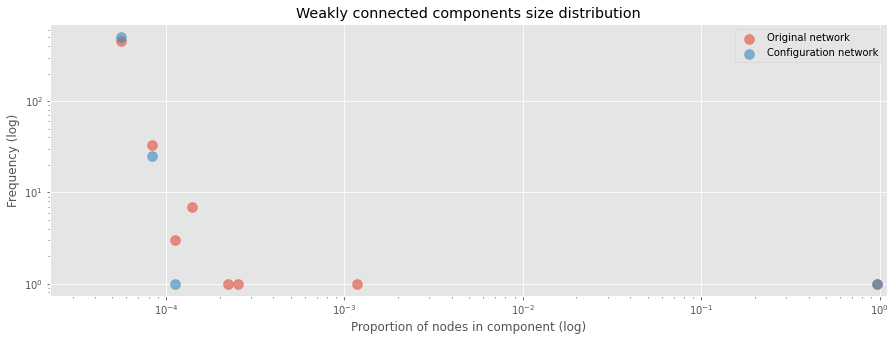

In [26]:
print("Number of weakly connected components in Reddit network: {}"
      .format(nx.number_weakly_connected_components(G)))
print("Number of weakly connected components in configuration network: {}"
      .format(nx.number_weakly_connected_components(conf_model)))
print("The largest weakly connected component in the Reddit network includes {} nodes"
      .format(len(max(nx.weakly_connected_components(G), key=len))))
print("The largest weakly connected component in the configuration network includes {} nodes"
      .format(len(max(nx.weakly_connected_components(conf_model), key=len))))

plot_component_distributions(G, conf_model, 
                             "Weakly connected components size distribution", 
                             component_method=nx.weakly_connected_components)

Number of strongly connected components in Reddit network: 24052
Number of strongly connected components in configuration network: 24477
The largest strongly connected component in the Reddit network includes 11507 nodes
The largest strongly connected component in the configuration network includes 11223 nodes


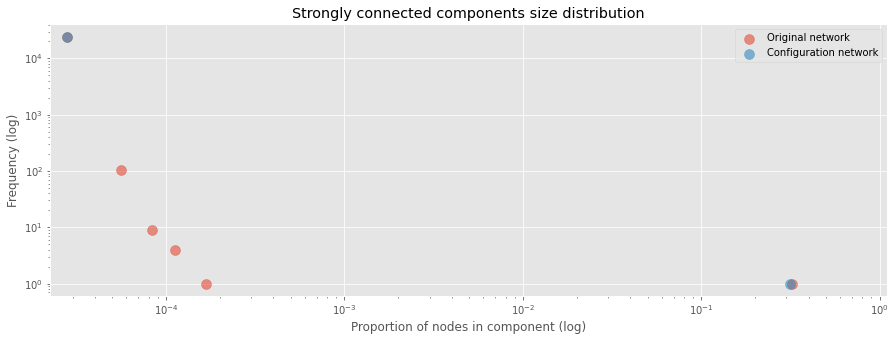

In [27]:
print("Number of strongly connected components in Reddit network: {}"
      .format(nx.number_strongly_connected_components(G)))
print("Number of strongly connected components in configuration network: {}"
      .format(nx.number_strongly_connected_components(conf_model)))
print("The largest strongly connected component in the Reddit network includes {} nodes"
      .format(len(max(nx.strongly_connected_components(G), key=len))))
print("The largest strongly connected component in the configuration network includes {} nodes"
      .format(len(max(nx.strongly_connected_components(conf_model), key=len))))

plot_component_distributions(G, conf_model, 
                             "Strongly connected components size distribution", 
                             component_method=nx.strongly_connected_components);

#### The component we are most interested in analyzing is the largest strongly connected component consisting on around 30% of the nodes in our network. The remaining strongly connected components are under 7 nodes each, so they're irrelevant for our research question.
#### We chose the largest strongly connected component over the largest weakly connected component since we found that nodes that only link to others without getting linked are usually not a relevant part of the communities we wished to research.

### Helper plotting functions

In [28]:
def plot_cumulative_distribution(values, bins = 100,xlabel = '',ylabel = '', 
                                 title = 'Complementary cumulative distribution',show = True ,hide_hist = True):
    """
    Shows the 1 - cumulative distribution of values.
    """
    n,x, _ = plt.hist(values , density= True, cumulative = True, bins = bins)
    
    if hide_hist:
        plt.close()
    
    # This line finds the middle of the histogram bins 
    bin_centers = 0.5*(x[1:]+x[:-1])
    #This line 1-bin height so this plot becomes a complementary cumulative distribution
    y = [1 - v for v in n] 
    
    
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gca().set_yscale("symlog", linthresh=0.00001)
    plt.gca().set_xscale("log")
    
    if show:
        plt.plot(bin_centers,y,'ro') ## using bin_centers rather than edges
        plt.show()
    else:
        plt.close()

        return bin_centers, y

    
def log_binned_prob_hist(values , bins_n = 15, logged = False,xlabel = 'k', ylabel = 'P(k)',
                         title = "Logarithmically binned degree distribution",show = True ,**params ):
    """
    This function shows a logarithmically binned histogram the input(values) is a list of integers or floats
    """
    maximum_value = params.get('maximum_value', max(values))          
    
    #This line is to create weights which are used to normalise input data so the output of the function is
    # a probability distribution
    weights = np.ones_like(values) / (len(values))
    
    #np.logspace generater num samples equally space out on a logscale 
    n,x, _  = plt.hist(values, bins=np.logspace(np.log10(1), np.log10(maximum_value), num = bins_n )
                       , weights = weights, log = True)
    plt.close()
    bin_centers = 0.5*(x[1:]+x[:-1])
    plt.gca().set_yscale("symlog", linthresh=0.0001)
    plt.gca().set_xscale("log")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.scatter(bin_centers,n)
    
    if show:
        plt.show()
    else:
        plt.close()
        return bin_centers ,n
    
# An easy way to plot the content of the counters
#I create this function because I will plot a lot of probability distribution functions in this notebook
def plot_counter(counter,degrees ,xlabel = '',ylabel = '',prob = True,**params):
    """
    The counter object is dictionary like object which containt a measure like a degree of a node as keys and
    the times it occured as values
    """
    
    lists = sorted(counter.items(), key = itemgetter(1)) # sorted by value
    x, y = zip(*lists) # unpack the list of keys, counts
    
    
    # If it is a probabilty distribution use the normalised y values
    p_y = y / np.sum(y) #probability of y
    if prob:
        y_s = p_y
    x_c, y_c = plot_cumulative_distribution(degrees ,show = False)
    x_l, y_l =log_binned_prob_hist(degrees ,show = False)
    
    plt.clf()
    
    plt.subplot(221)
    plt.title('Linear Scale')
    plt.xlabel('k')
    plt.ylabel('P(k)')
    if params.get('has_xlim',False):
        plt.xlim(params['left'],params['right'])
    plt.plot(x,y_s, "ro")
    
    
    plt.subplot(222)
    plt.title('Logarithmic Scale')
    plt.xlabel('k')
    plt.ylabel('P(k)')
    plt.gca().set_yscale("symlog", linthresh=0.01)
    plt.gca().set_xscale("log")
    if params.get('has_xlim',False):
        plt.xlim(params['left'],params['right'])
    plt.loglog(x,y_s, "ro")

    plt.subplot(223)
    
    plt.gca().set_yscale("symlog", linthresh=0.01)
    plt.gca().set_xscale("log")
    plt.title("Logarithmically binned distribution")
    plt.xlabel('k')
    plt.ylabel('P(k)')
    plt.plot(x_l, y_l,'ro')
    
    plt.subplot(224)
    
    plt.title('Complementary cumulative distribution')
    plt.xlabel('x')
    plt.ylabel('P(x>k)')
    plt.gca().set_yscale("symlog", linthresh=0.01)
    plt.gca().set_xscale("log")
    plt.plot(x_c, y_c,'ro')
    
    # This part is responsable for the legend
    if params.get('has_legend', False):
        legend_text = xlabel + ' =' + params['xmeaning'] + '\n' + ylabel + ' =' + params['ymeaning']
        plt.annotate(legend_text, xy=(250, -50), xycoords='axes points',
            size=14, ha='left', va='top',
            bbox=dict(boxstyle='round', fc='w'))
    plt.subplots_adjust(hspace = 0.5)
    plt.show()

## In-Degree Distribution

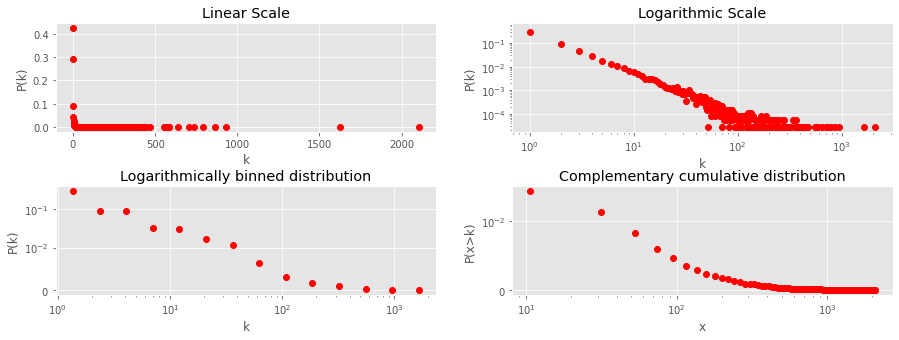

Largest in degree of any node in the Reddit network: 2105


In [29]:
in_degrees = np.array(list(dict(G.in_degree).values()))
in_degree_count = Counter(dict(G.in_degree).values())

plot_counter(in_degree_count,in_degrees,xlabel =  'k_in',ylabel ='P(k_in)')

print("Largest in degree of any node in the Reddit network: {}"
      .format(max(in_degree_count.keys())))

### We can look at the network to see which are the subreddits at the end of the scale (the ones that are linked the most):

In [30]:
print('10 most linked subreddits')
indic = {k: v for k, v in sorted(dict(G.in_degree).items(), key=lambda item: item[1], reverse=True)}
a = list({k: v for k, v in sorted(dict(G.in_degree).items(), key=lambda item: item[1], reverse=True)})[:10]
b = []
for key in a:
    b.append((key,indic[key]))
b

10 most linked subreddits


[('askreddit', 2105),
 ('iama', 1625),
 ('pics', 933),
 ('videos', 864),
 ('todayilearned', 793),
 ('funny', 734),
 ('writingprompts', 705),
 ('worldnews', 639),
 ('outoftheloop', 585),
 ('mhoc', 583)]

## Out-Degree Distribution

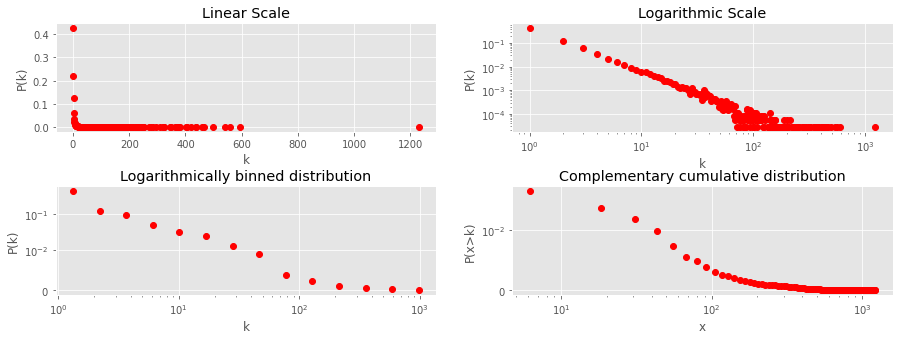

Largest in-degree of any node in the network: 1230


In [31]:
out_degrees = np.array(list(dict(G.out_degree).values()))
out_degree_count = Counter(dict(G.out_degree).values())

plot_counter(out_degree_count,out_degrees,xlabel =  'k_in',ylabel ='P(k_in)')

print("Largest in-degree of any node in the network: {}"
      .format(max(out_degree_count.keys())))

### We can look at the network to see which are the subreddits at the end of the scale (the most active subreddits in terms of linkings):

In [32]:
print('10 subreddits that link the most')
outdic = {k: v for k, v in sorted(dict(G.out_degree).items(), key=lambda item: item[1], reverse=True)}
a = list({k: v for k, v in sorted(dict(G.out_degree).items(), key=lambda item: item[1], reverse=True)})[:10]
b = []
for key in a:
    b.append((key,outdic[key]))
b

10 subreddits that link the most


[('subredditdrama', 1230),
 ('copypasta', 593),
 ('subredditoftheday', 557),
 ('drama', 540),
 ('outoftheloop', 497),
 ('tipofmypenis', 465),
 ('justunsubbed', 459),
 ('circlejerkcopypasta', 438),
 ('shitliberalssay', 437),
 ('hailcorporate', 419)]

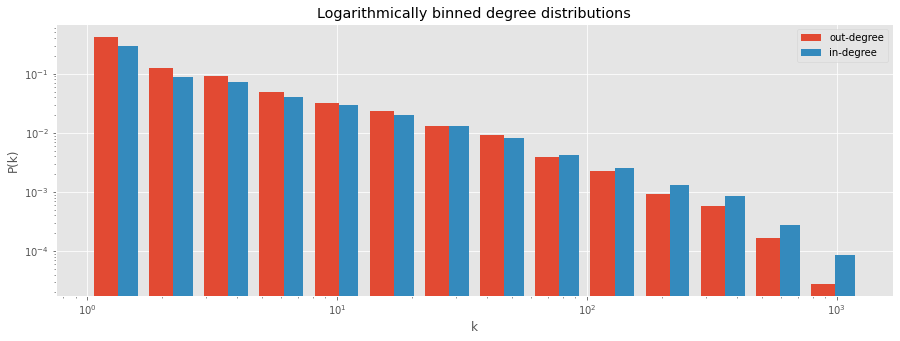

In [33]:
weights = np.ones_like(out_degrees) / (len(out_degrees))

names = ['out-degree', 'in-degree']
plt.hist([out_degrees,in_degrees], 
         bins=np.logspace(np.log10(1),np.log10(max(out_degrees)),num = 15), weights = [weights,weights], label=names)
plt.gca().set_xscale("log")
plt.title("Logarithmically binned degree distributions")
plt.legend()
plt.ylabel("P(k)")
plt.xlabel('k')

plt.yscale('log')
plt.show()

### As we can see, it's much more common to receive a lot of links than to send them. On the other hand, there is a greater quantity of subreddits with a small out-degree. This means that on average, many subreddits link to few big ones.

# Contructing a random network null model
 
#### We construct a Erdős–Rényi random graph to compare our degree distribution and understand if it is due to our network size or some other underlying property.

In [34]:
def construct_random_graph(G):
    """
    Constructs an Erdős-Rényi random network null model for a NetworkX graph. 
    Copies node attributes from G to random graph.
        @G: NetworkX Graph or DiGraph object
    Returns
        NetworkX Graph or DiGraph object with connections chosen uniformly at random
    """
    
    # extract number of nodes and edges
    num_nodes = nx.number_of_nodes(G)
    num_edges = nx.number_of_edges(G)
    
    # extract list of nodes in original graph
    nodes = dict(G.nodes(data=True))
    
    # initilize mapping between original node name and idx value in random graph
    node_idx_map = {}
    
    idx = 0
    random_graph_node_attributes = {}
    
    # loop over each node and corresponding attributes in original graph
    for name, attributes in nodes.items():
        attribs = attributes
        
        # set name/id in original graph as 'original_id' attribute 
        attribs['original_id'] = name
        random_graph_node_attributes[idx] = attribs
        
        # update node -> idx mapping and increment idx
        node_idx_map[name] = idx
        idx += 1
        
    # construct random graph
    G_random = nx.gnm_random_graph(n=num_nodes, m=num_edges, seed=42, directed=nx.is_directed(G))
    
    # add node attributes from dict
    nx.set_node_attributes(G_random, values=random_graph_node_attributes)
    
    return G_random

In [35]:
G_random = construct_random_graph(G)
print(nx.info(G_random))

Name: 
Type: DiGraph
Number of nodes: 35699
Number of edges: 135707
Average in degree:   3.8014
Average out degree:   3.8014


#### As we can see, the ER network has the same number of nodes, edges and average degree. Let us now see how the degree distribution looks like for the ER model.

# ER model Out-Degree vs. Reddit Out-Degree

Random Network


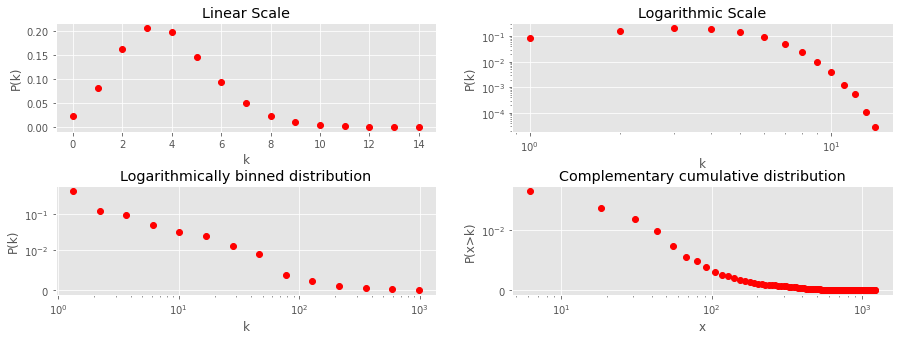

Largest in-degree of any node in the random network: 14

Reddit Network


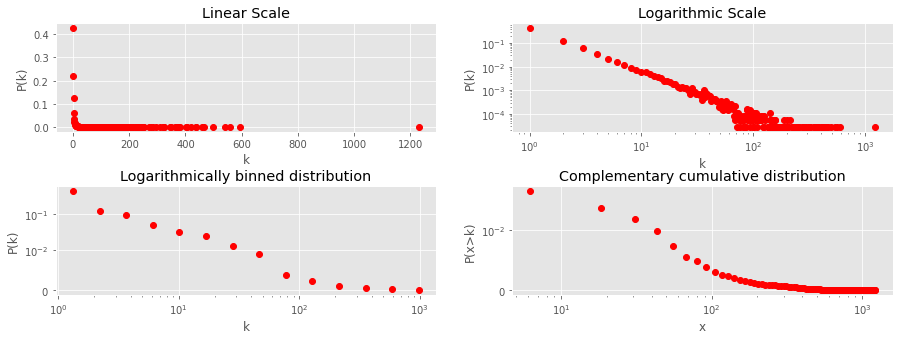

Largest in-degree of any node in the Reddit network: 1230


In [36]:
print("Random Network")

out_degree_count = Counter(dict(G_random.out_degree).values())

plot_counter(out_degree_count,out_degrees,xlabel =  'k_in',ylabel ='P(k_in)')

print("Largest in-degree of any node in the random network: {}"
      .format(max(out_degree_count.keys())))

print("\nReddit Network")

out_degree_count = Counter(dict(G.out_degree).values())

plot_counter(out_degree_count,out_degrees,xlabel =  'k_in',ylabel ='P(k_in)')

print("Largest in-degree of any node in the Reddit network: {}"
      .format(max(out_degree_count.keys())))

#### Comparing the degree distributions, we can clearly see that our network's distribution is not due to random chance, but due to some of its underlying properties. We will now try to see what kind of distribution our network follows.

# Comparing fits

In [37]:
def compare_fits(fitoutput):
    """
    Prints the pairwise comparison of distribution fits from the output of powerlaw.Fit()
         @fitoutput: Output of powerlaw.Fit() to the degree distribution of a network 
    """
    distribution_names = ['power_law', 'exponential', 'lognormal', 'truncated_power_law']

    # loop over each pairwise combination of the three distributions
    for f1, f2 in itertools.combinations(distribution_names, 2):
        R, p = fitoutput.distribution_compare(f1, f2)
        print("Result of {} vs. {}: R = {}, p = {}"
             .format(f1, f2, R, p))
        
    # print optimal parameters
    print("\n\nOPTIMAL PARAMETERS:")
    print(" * Power law: alpha = {:.6}".format(fitoutput.power_law.alpha))
    print(" * Lognormal:  mu = {:.6}, sigma = {:.6}".format(fitoutput.lognormal.mu, fitoutput.lognormal.sigma))
    print(" * Exponential: lambda = {:.6}".format(fitoutput.exponential.Lambda))
    print(" * Power law w. exponential cutoff: lambda = {:.6}, alpha = {:.6}"
          .format(fitoutput.truncated_power_law.Lambda, fitoutput.truncated_power_law.alpha))
    
def plot_ccdf(fitoutput, title="CCDF"):
    """
    Plots complement of a cumulative distribution (CCDF) from the output of a 
    degree distribution fitted using the powerlaw package
        @fitoutput: Output of powerlaw.Fit() to the degree distribution of a network 
    """
    plt.figure()
    fig1 = fitoutput.plot_ccdf(label='CCDF', linestyle='--', marker='o')
    plt.title(title)
    plt.legend()
    plt.ylim(0.001, 1.2)
    plt.xlabel('$x$')
    plt.ylabel('$P(k>=x)$')
    plt.show()
    
def plot_ccdf_with_fits(fitoutput, title="CCDF"):
    """
    Plots complement of a cumulative distribution (CCDF) from the output of a 
    degree distribution fitted using the powerlaw package
        @fitoutput: Output of powerlaw.Fit() to the degree distribution of a network 
    """
    plt.figure()
    fig1 = fitoutput.plot_ccdf(label='CCDF', linestyle='--', marker='o')
    
    # add fitted powerlaw, exponential and lognormal CCDF plots as dashed lines
    fitoutput.power_law.plot_ccdf(ax=fig1, color='r', linestyle='--', label='power-law fit')
    fitoutput.exponential.plot_ccdf(ax=fig1, color='g', linestyle='--', label='exponential fit')
    fitoutput.lognormal.plot_ccdf(ax=fig1, color='b', linestyle='--', label='lognormal fit')
    fitoutput.truncated_power_law.plot_ccdf(ax=fig1, color='k', linestyle='--', label='Powerlaw w. exp. cutoff')

    plt.title(title)
    plt.legend()
    plt.ylim(0.001, 1.2)
    plt.xlabel('$x$')
    plt.ylabel('$P(x>k)$')
    plt.show()

In [40]:
# Extract the list of all node degrees in the network for in- and out-degrees
degrees_in = np.array(list(dict(G.in_degree).values()))
degrees_out = np.array(list(dict(G.out_degree).values()))

# fit each degree distribution using powerlaw
fitoutput_in = powerlaw.Fit(degrees_in, verbose=False)
fitoutput_out = powerlaw.Fit(degrees_out, verbose=False)

# Positive R means better fit for the first distribution. If p > 0.05, the algorithm can't determine what's better.
print("Comparisons of distribution fits for the Reddit network in-degrees:\n")
compare_fits(fitoutput_in)
print("\n\n")
print("Comparisons of distribution fits for the Reddit network out-degrees:\n")
compare_fits(fitoutput_out)

Comparisons of distribution fits for the Reddit network in-degrees:

Result of power_law vs. exponential: R = 173.68101631170055, p = 6.341899091872853e-07
Result of power_law vs. lognormal: R = -1.344929421891182, p = 0.2994708907057988
Result of power_law vs. truncated_power_law: R = -2.790926625030952, p = 0.018147509087191538
Result of exponential vs. lognormal: R = -175.02594573359082, p = 2.239384305862914e-07
Result of exponential vs. truncated_power_law: R = -176.47194293673107, p = 1.2522698970954357e-07
Result of lognormal vs. truncated_power_law: R = -1.4459972031398634, p = 0.037976918341344035


OPTIMAL PARAMETERS:
 * Power law: alpha = 2.33059
 * Lognormal:  mu = -5.45178, sigma = 2.78729
 * Exponential: lambda = 0.0154458
 * Power law w. exponential cutoff: lambda = 0.000684016, alpha = 2.19002



Comparisons of distribution fits for the Reddit network out-degrees:

Result of power_law vs. exponential: R = 116.3886705779321, p = 4.040321405075163e-07


Assuming nested distributions
Assuming nested distributions


Result of power_law vs. lognormal: R = -0.7955776096979399, p = 0.405833710369655
Result of power_law vs. truncated_power_law: R = -2.0757482846722493, p = 0.041597743160309286
Result of exponential vs. lognormal: R = -117.18424818763097, p = 1.2134246453350433e-07
Result of exponential vs. truncated_power_law: R = -118.46441886260442, p = 5.644661786178759e-08
Result of lognormal vs. truncated_power_law: R = -1.280170674974285, p = 0.015844993542399273


OPTIMAL PARAMETERS:
 * Power law: alpha = 2.53748
 * Lognormal:  mu = -6.75411, sigma = 2.73402
 * Exponential: lambda = 0.020424
 * Power law w. exponential cutoff: lambda = 0.00104677, alpha = 2.37081


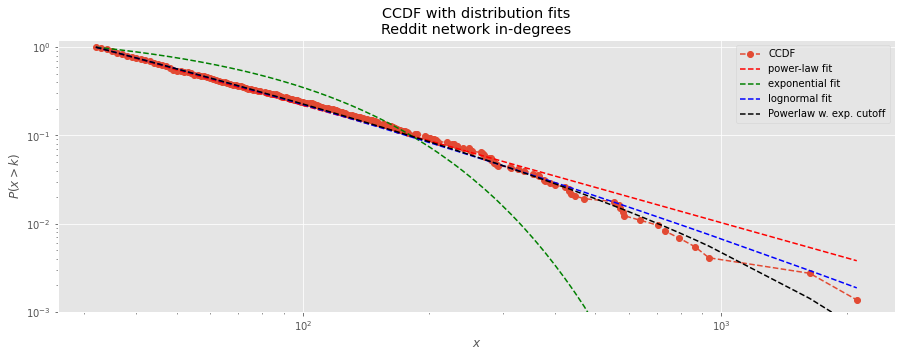

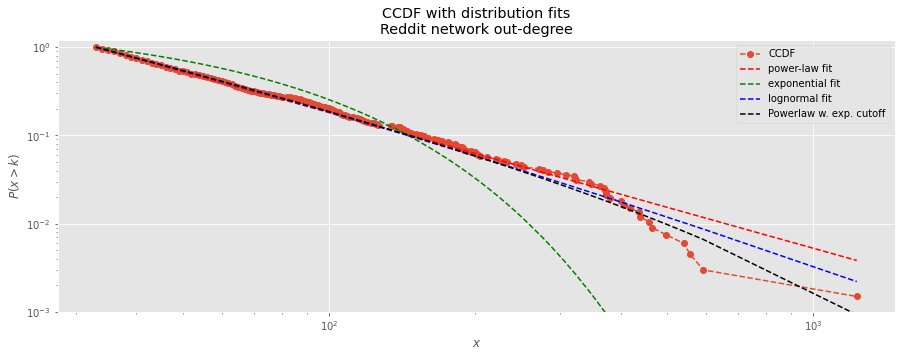

In [41]:
# Plot the CCDF distribution fits
plot_ccdf_with_fits(fitoutput_in, "CCDF with distribution fits\nReddit network in-degrees")
plot_ccdf_with_fits(fitoutput_out, "CCDF with distribution fits\nReddit network out-degree")

#### Getting the degree exponent γ of the network:

In [42]:
warnings.simplefilter('ignore')
results_in = powerlaw.Fit(degrees_in)
results_out = powerlaw.Fit(degrees_out)
print(f"The in-degree exponent γ is {results_in.power_law.alpha}")
print(f"The out-degree exponent γ is {results_out.power_law.alpha}")

The in-degree exponent γ is 2.330591478179871
The out-degree exponent γ is 2.5374838612134676


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


#### Our distribution fit comparison shows that powerlaw with exponential cutoff is the best fit for our network. Our network is then (at least for the most part) scale free, and a γ of approximately 2.5 points towards an Ultra-Small World network.
#### We will now calculate the shortest path length distribution for a sampling of 5000 nodes in each network.

In [43]:
def sample_shortest_path_lengths(G, n=1000):
    """
    Samples n shortest lengths from random pairs of n nodes in the network
    """
    
    sp_lengths = []
    
    # extract all nodes and shuffle order
    nodes = list((G.nodes()))
    random.shuffle(nodes)
    
    # get all pairs of n nodes and shuffle pairs
    node_pairs = list(itertools.combinations(nodes[:n], 2))
    random.shuffle(node_pairs)
    
    diam = 0
    # take shortest path length until n lengths is reached
    for source, target in node_pairs:
        if not nx.has_path(G, source, target):
            continue
        shortest = len(nx.shortest_path(G, source, target))
        sp_lengths.append(shortest)
        if len(sp_lengths) > n:
            break
        if shortest > diam:
            diam = shortest
    return (sp_lengths, diam)

def compare_distributions(title, dist1, dist2, xlabel, log=False, bins=20):
    """
    Plots two distributions on a single plot. 
    Plots histogram output as scatter plot with x-ticks marking bin centers 
        @title: plot title
        @dist1 (list): distribution from original network
        @dist2 (list): ditribution from random network null model
        @xlabel (str): label on x-axis
        @log (boolean): If True, logscales y-axis
        @bins (int or list): number of histogram bins or list with pre-defined bin edges
    """
        
    # get histogram scatter points of distribution 1
    n_1, x_1, _ = plt.hist(dist1, bins = bins)
    bin_centers_1 = 0.5*(x_1[1:]+x_1[:-1])
    plt.close()
    
    # get histogram scatter points of distribution 2
    n_2, x_2, _ = plt.hist(dist2, bins = bins)
    bin_centers_2 = 0.5*(x_2[1:]+x_2[:-1])
    plt.close()
    
    # initilize subplots
    fig, (ax1) = plt.subplots(1, 1, figsize=(15, 10))
    
    # set y logscale if specified
    if log:
        ax1.set_yscale("symlog")

    
    # plot distribution from original network
    ax1.scatter(bin_centers_1, n_1, label='Reddit network', s=100)
    
    # add mean as vertical line
    ax1.axvline(x=np.mean(dist1), label='Reddit network mean: {:.3}'.format(np.mean(dist1)), 
                color='#f2ada2', linestyle='--')
    
    
    # if bins is list, set x-ticks as bin centers and rotate xlabels 
    if isinstance(bins, list):
        ax1.set_xticks(bin_centers_1)
        ax1.set_xlim(min(bins), max(bins))
        ax1.tick_params(axis='x', labelrotation=90)

    ax1.set_title(title)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel("Frequency")
        
    # plot distribution from Configuration network
    ax1.scatter(bin_centers_2, n_2, label='Null model', s=100)
    ax1.axvline(x=np.mean(dist2), label='Null model mean: {:.3}'.format(np.mean(dist2)), 
                color='#9fc1d6', linestyle='--')

    ax1.legend(loc='best')

    plt.show()

In [44]:
def get_largest_strong_component(DiGraph):
    
    components_sorted = sorted( nx.strongly_connected_components(DiGraph) , key=len, reverse=True )
    return DiGraph.subgraph( components_sorted[0] )

def get_sampled_shortest_path_lens(Graph , number_of_paths = 10000):
    
    path_lens = []
    diam = 0
    for i in range(number_of_paths):
        
        #if i % 100 == 0:
        #   print(i)
        
        nodes = random.sample(Graph.nodes(),2) # RS: explain that with this you avoid taking the shortest path between a node and itself
        shortest_path = nx.shortest_path(Graph, source=nodes[0], target=nodes[1])
        path_lens.append(len(shortest_path))

    return path_lens
    
def hist_counter(counter,xlabel = '',ylabel = '',prob = True,**params):
    lists = sorted(counter.items(), key = itemgetter(1)) # sorted by value
    x, y = zip(*lists) # unpack the list of keys, counts
    p_y = y / np.sum(y) #probability of y
    
    if prob:
        y = p_y

    plt.clf()
    plt.subplot(121)
    plt.title('Shortest path distribution')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(1, max(x)+1, 1.0))
    
    if params.get('has_xlim',False):
        plt.xlim(params['left'],params['right'])
        
    plt.bar(x ,y)
    
    if params.get('has_legend',False):
        legend_text = xlabel + ' =' + params['xmeaning'] + '\n' + ylabel + ' =' + params['ymeaning']
        plt.annotate(legend_text, xy=(250, -50), xycoords='axes points',
            size=14, ha='left', va='top',
            bbox=dict(boxstyle='round', fc='w'))

    plt.show()    

largest_strong_component = get_largest_strong_component(G)
shortest_path_len_counts = Counter(get_sampled_shortest_path_lens(largest_strong_component))

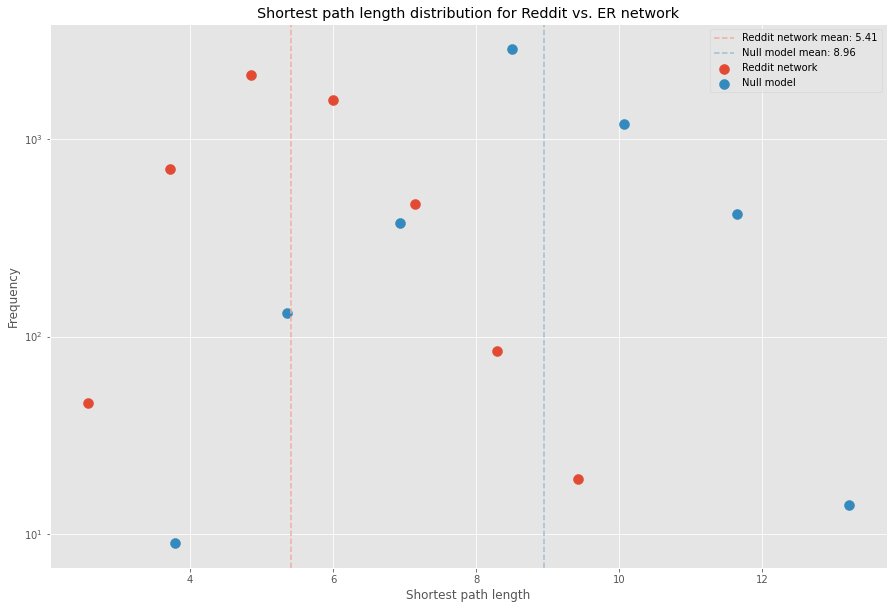

Diameter for Reddit is 10
Diameter for the ER Network is 14


In [45]:
# sample 5000 shortest path lengths from each network
shortest_paths, reddit_diam = sample_shortest_path_lengths(G, n=5000)
shortest_paths_random, random_diam = sample_shortest_path_lengths(G_random, n=5000)
shortest_paths_conf, conf_diam = sample_shortest_path_lengths(conf_model, n=5000)

compare_distributions('Shortest path length distribution for Reddit vs. ER network', 
                      shortest_paths, shortest_paths_random, 
                      "Shortest path length", log=True, bins = 7)

print("Diameter for Reddit is", reddit_diam)
print("Diameter for the ER Network is", random_diam)

#### As we can see, the mean shortest path length in the Reddit network is smaller than that of the random network. This is probably due to the prevalence of hubs in our network (remember that our network has nodes with degree in the order of thousands, while the random network has a maximum degree of 14). This average distance is more in line with a critical point γ of 3 than an ultra-small world γ between 2 and 3, where we would expect an average distance of 2.35.

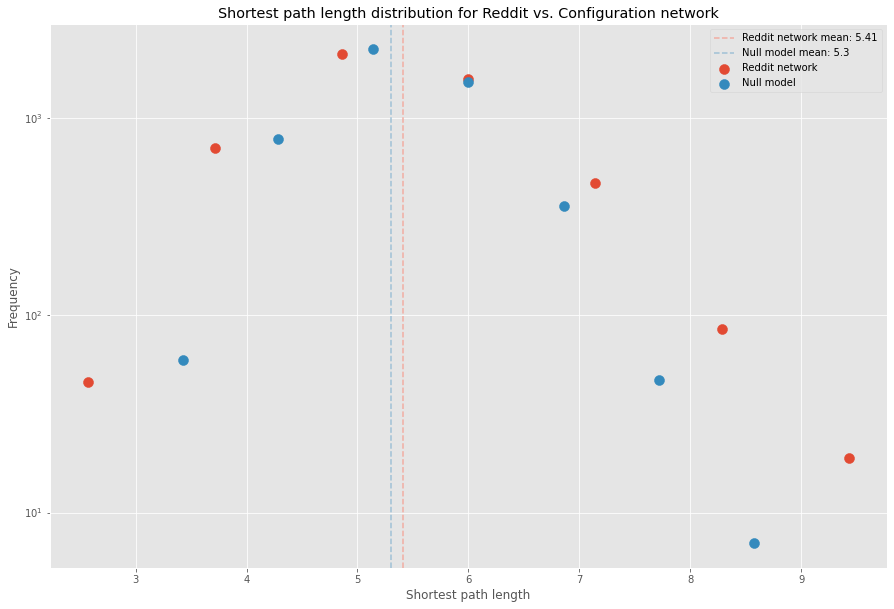

Diameter for Reddit is 10
Diameter for the Configuration Network is 9


In [46]:
compare_distributions('Shortest path length distribution for Reddit vs. Configuration network', 
                      shortest_paths, shortest_paths_conf, 
                      "Shortest path length", log=True, bins = 7)

print("Diameter for Reddit is", reddit_diam)
print("Diameter for the Configuration Network is", conf_diam)

#### When we compare average path length of the Reddit network to the configuration network, they're very similar. It is interesting to note that while the configuration network has a smaller diameter, it has fewer short paths than the Reddit network. This may be due to the pressence of a community structure in the Reddit network, which would be less prevalent in a random network like the one created by a configuration model.

# Centrality distributions
### Calculating betweenness, closeness and eigen centralities

In [47]:
def get_largest_strong_component(DiGraph):
    '''
    Helper function for getting the largest strongly connected component.
    '''
    components_sorted = sorted(nx.strongly_connected_components(DiGraph) , key=len, reverse=True )
    return DiGraph.subgraph(components_sorted[0])

conf_model = nx.DiGraph(conf_model) #Removing self loops so we can run centralities

In [48]:
b_centrality = list(nx.betweenness_centrality(G, k = 1000).values())
conf_b_centrality = list(nx.betweenness_centrality(conf_model, k = 1000).values())

In [50]:
# Takes A LONG time to run

largest = get_largest_strong_component(G)
largest_conf = get_largest_strong_component(conf_model)

sampled_nodes = random.sample(largest.nodes(),1000)
closeness = {}
for node in sampled_nodes:
    closeness[node] = nx.closeness_centrality(largest,u = node)
closeness = list(closeness.values())

conf_sampled_nodes = random.sample(largest_conf.nodes(),1000)
conf_closeness = {}
for node in conf_sampled_nodes:
    conf_closeness[node] = nx.closeness_centrality(largest_conf,u = node)
conf_closeness = list(conf_closeness.values())

In [51]:
eigen_centrality = list(dict(nx.eigenvector_centrality(G)).values())
conf_eigen_centrality = list(dict(nx.eigenvector_centrality(nx.Graph(conf_model))).values())

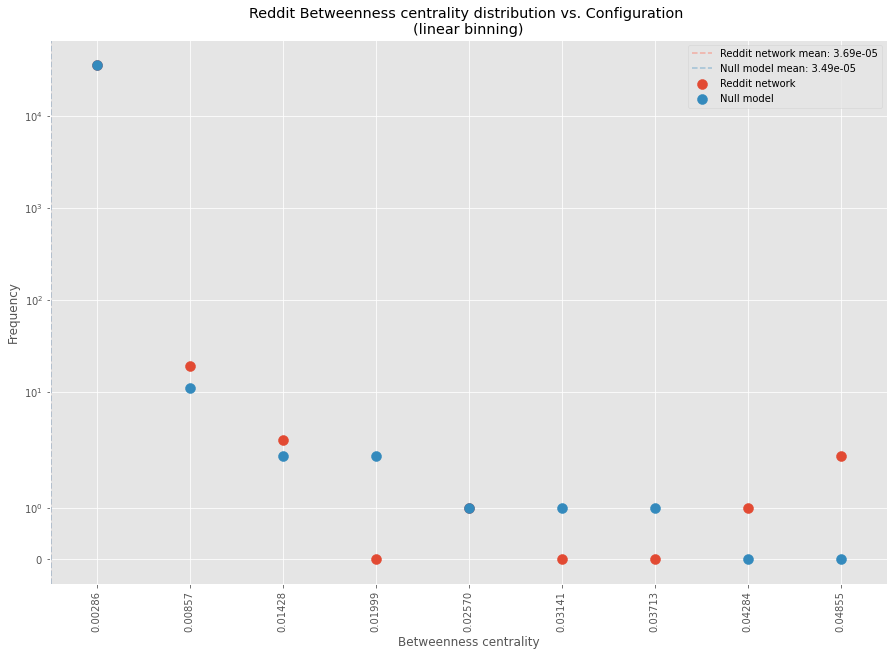

In [52]:
# plot distributions with 10 linear bins
compare_distributions('Reddit Betweenness centrality distribution vs. Configuration \n(linear binning)', 
                      b_centrality,conf_b_centrality, "Betweenness centrality", 
                      log=True, bins=list(np.linspace(min((b_centrality + conf_b_centrality)), 
                                                      max((b_centrality + conf_b_centrality)),
                                                      10, endpoint=True)))

#### It is interesting to see that the Reddit network has a higher percentage of high betwenness centrality than the configuration network. This may again be due to the prevalent community structure in the Reddit network. We expected to see this given that we had a number of high degree nodes that connected to a large portion of the network. This makes sense, as the default subreddits tend to be known by most of the network.

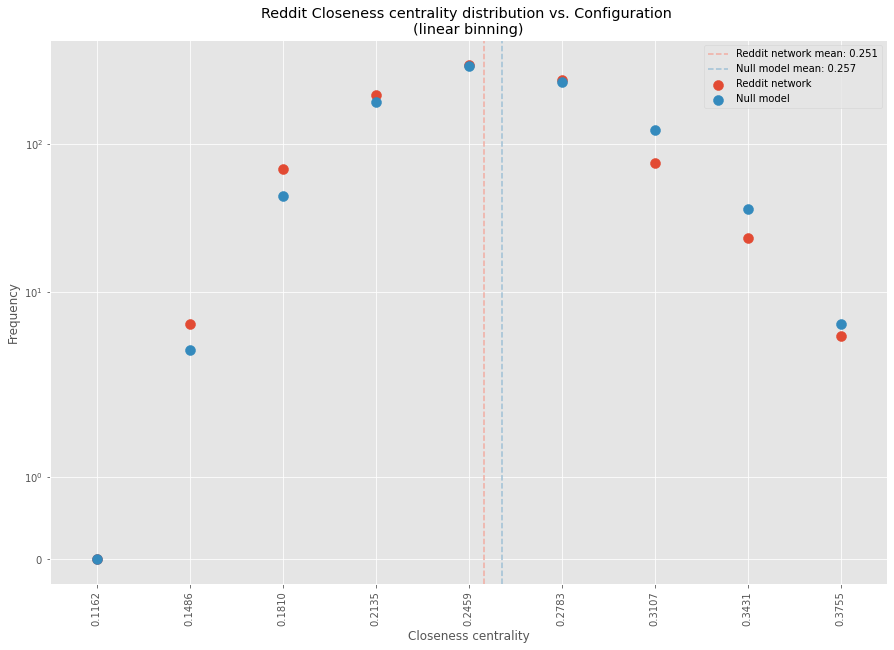

In [54]:
# plot distributions with 10 linear bins
compare_distributions('Reddit Closeness centrality distribution vs. Configuration \n(linear binning)', 
                      closeness,conf_closeness, "Closeness centrality", 
                      log=True, bins=list(np.linspace(0.1, 
                                                      max((conf_closeness + closeness)),
                                                      10, endpoint=True)))

#### Closeness centrality in the Reddit network appears to be extremely close to the configuration network, so closeness centrality in the Reddit network appears to be related to its degree distribution. 

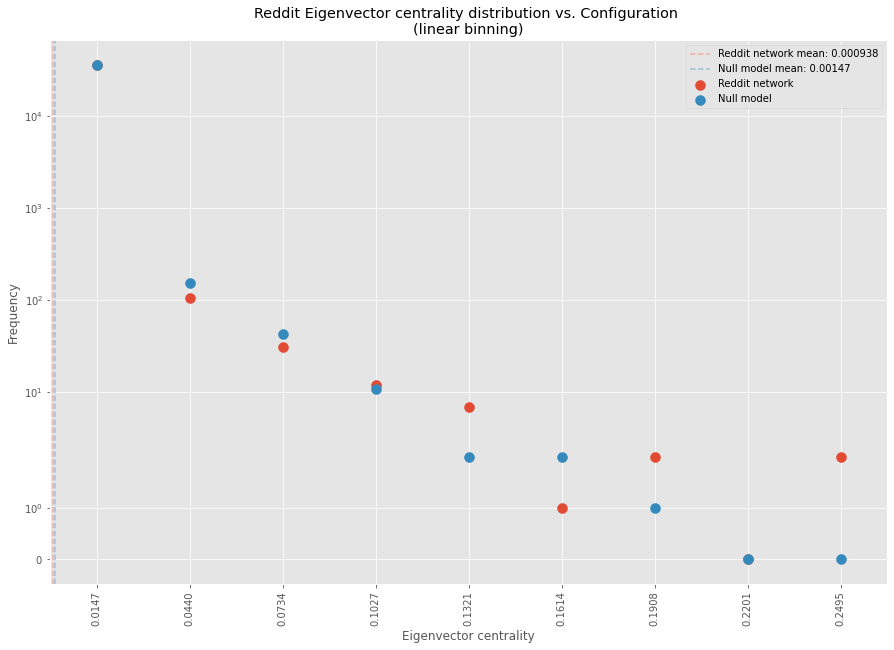

In [55]:
# plot distributions with 10 linear bins
compare_distributions('Reddit Eigenvector centrality distribution vs. Configuration \n(linear binning)', 
                      eigen_centrality,conf_eigen_centrality, "Eigenvector centrality", 
                      log=True, bins=list(np.linspace(min((eigen_centrality + conf_eigen_centrality)), 
                                                      max((eigen_centrality + conf_eigen_centrality)),
                                                      10, endpoint=True)))

#### Most interesting is the end of the graph. We see that the reddit network has a significantly higher frequency of high eigencentrality nodes compared to the configuration network. This is due to the reddit network consisting of hubs and communities with presumably very high importance for the network, and since these are so essential to the network's structure, we see a high frequency of high eigencentralities.

# Clustering coefficient

In [57]:
# An easy way to plot the content of the counters
#I create this function because I will plot a lot of probability distribution functions in this notebook
def plot_counter2(counter,xlabel = '',ylabel = '',prob = True,**params):
    lists = sorted(counter.items(), key = itemgetter(1)) # sorted by value
    x, y = zip(*lists) # unpack the list of keys, counts
    p_y = y / np.sum(y) #probability of y
    

    
    if prob:
        y = p_y
    
    plt.clf()
    plt.subplot(121)
    plt.title('Linear Scale')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if params.get('has_xlim',False):
        plt.xlim(params['left'],params['right'])
    plt.plot(x, y, "ro")

    plt.subplot(122)
    plt.title('Logarithmic Scale')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if params.get('has_xlim',False):
        plt.xlim(params['left'],params['right'])
    plt.loglog(x, y, "ro")
    
    
    
    if params.get('has_legend',False):
        legend_text = xlabel + ' =' + params['xmeaning'] + '\n' + ylabel + ' =' + params['ymeaning']
        plt.annotate(legend_text, xy=(250, -50), xycoords='axes points',
            size=14, ha='left', va='top',
            bbox=dict(boxstyle='round', fc='w'))
    
    plt.show()

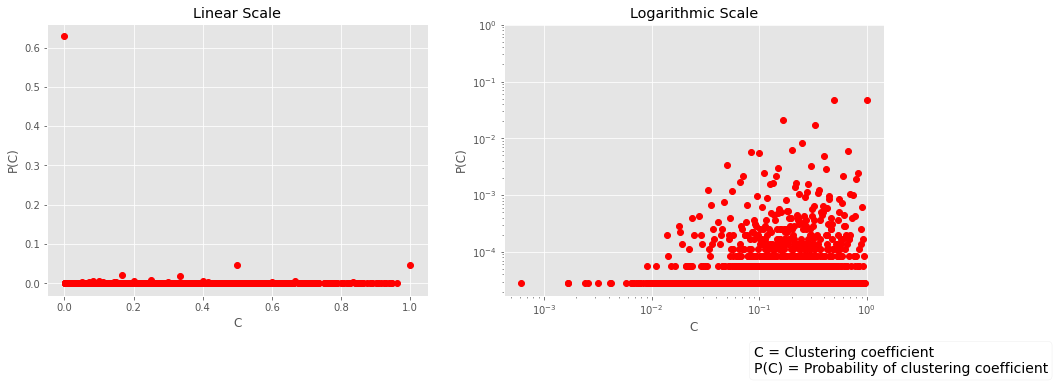

The global clustering coefficient of the network: 0.13574375123352495


In [58]:
nodes_clustering = nx.clustering(G)
clustering_count = Counter(nodes_clustering.values())
plot_counter2(clustering_count,xlabel = "C", ylabel = "P(C)" ,has_legend = True,
             xmeaning = ' Clustering coefficient', ymeaning = ' Probability of clustering coefficient')
clustering_coefficient = nx.average_clustering(G)
print("The global clustering coefficient of the network: {}".format(clustering_coefficient))

#### We expect a decently high clustering coefficient, and that is also what we see. About 13% of the nodes in the network are grouped together in closed triangles, which is fairly high. The biggest part of our network however consists of nodes with a clustering coefficient of 0.


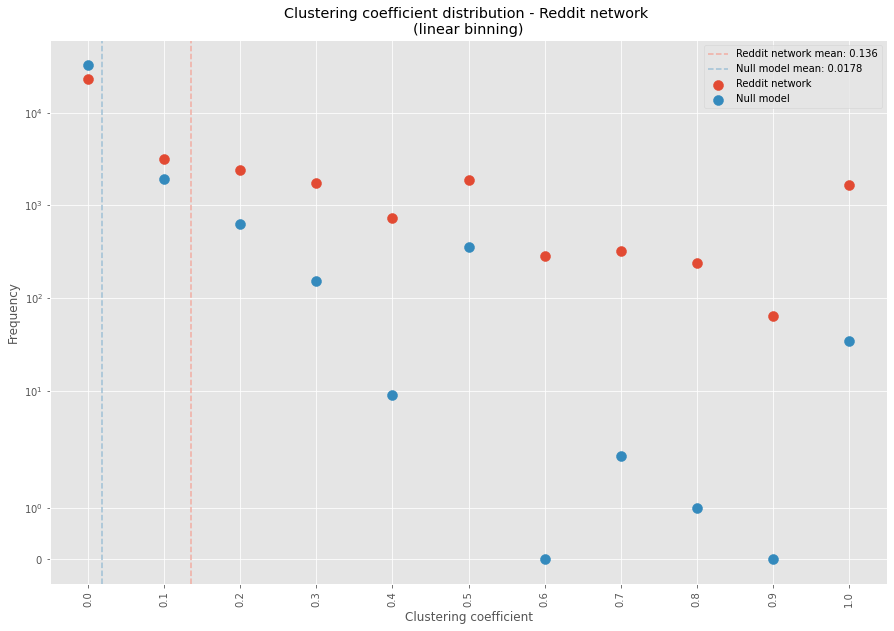

In [59]:
cc_dist = list(dict(nx.clustering(G)).values())
configuration_cc_dist = list(dict(nx.clustering(nx.DiGraph(conf_model))).values())

compare_distributions('Clustering coefficient distribution - Reddit network \n(linear binning)', 
                      cc_dist, configuration_cc_dist, "Clustering coefficient", 
                      log=True, bins=[-0.05, 0.05, 0.15, 0.25, 0.35, 0.45, 
                                      0.55, 0.65, 0.75, 0.85, 0.95, 1.05])

#### In the clustering coefficient distribution, we see that the Reddit network has significantly higher values across the board. We expected high values, but not this much higher than the configuration network. However, this is still really great results, and it strongly supports our hypothesis of Reddit having an underlying community structure. High clustering coefficients mean that neighbors of nodes often interconnect with each other, forming communities as we expected. It makes sense considering Reddit is split up into different Subreddits with different themes. The Subreddits with related themes will likely link to each other, and this property is not mirrored to the same extent by the configuration model, despite sharing the same degree sequence.

## Assortativity/degree correlations

In [60]:
options = ["in", "out"]
for a in options:
    for b in options:
        g_assort = nx.degree_assortativity_coefficient(G, x=a, y=b)
        conf_assort = nx.degree_assortativity_coefficient(conf_model, x=a, y=b)
        print(f"For {a} and {b}")
        print(f"The assortativty of the reddit network is {g_assort}\nThe assortativty of the configuration model is {conf_assort}\n")

For in and in
The assortativty of the reddit network is -0.04416376356088378
The assortativty of the configuration model is -0.03790859606084334

For in and out
The assortativty of the reddit network is -0.031641618417162266
The assortativty of the configuration model is -0.023944660199644786

For out and in
The assortativty of the reddit network is -0.08096813041265959
The assortativty of the configuration model is -0.06532125219040866

For out and out
The assortativty of the reddit network is -0.05499043204738856
The assortativty of the configuration model is -0.04052446924806304



#### The Reddit network is slightly more disassortative across the board than the configuration model, implying that the degree distribution alone doesn't account for the slight disassortativity of our network. 

# Community Detection

#### We decided on separating positive and negative edges when doing community detection, since making no distinction lead to less clear communities with overlapping topics. The positive communities have a surprisingly clear and identifiable main topic. However, the negative communities seem random, with little to no shared topic between them. This was relatively surprising, as we were expecting rivaling subreddits to have similar topics (e.g. two rivaling football subreddits or two subreddits on different sides of the political spectrum).

#### We had to decide between keeping the direction of our edges or considering our graph as undirected. We chose the former, since that filtered out small or unrelated subreddits that were so obscure as to not receive links from anyone else in the network.

#### During our work, we discovered that the two biggest detected communities had clearly identifiable subcommunities as well, and performing community detection on these communities gave us an insight into the subcommunities within.

In [61]:
# Read network as directed graph from edge list
G = pd.read_csv('clean_graph.csv', delimiter=",")

# Remove two big subreddits that several different communities interact with. This makes it so that communities are more clearly defined by infomap.
G = G[G.SOURCE_SUBREDDIT != 'askreddit']
G = G[G.SOURCE_SUBREDDIT != 'iama']
G = G[G.TARGET_SUBREDDIT != 'askreddit']
G = G[G.TARGET_SUBREDDIT != 'iama']

# Separate into negative and positive
DF_POS = G[G.LINK_SENTIMENT == 1]
DF_NEG = G[G.LINK_SENTIMENT == -1]

# Load into nx
G_POS = nx.convert_matrix.from_pandas_edgelist(DF_POS, source="SOURCE_SUBREDDIT", target="TARGET_SUBREDDIT", edge_attr="LINK_SENTIMENT", create_using=nx.DiGraph)
G_NEG = nx.convert_matrix.from_pandas_edgelist(DF_NEG, source="SOURCE_SUBREDDIT", target="TARGET_SUBREDDIT", edge_attr="LINK_SENTIMENT", create_using=nx.DiGraph)

# print summary of network
print(nx.info(G_NEG))

Name: 
Type: DiGraph
Number of nodes: 4863
Number of edges: 7463
Average in degree:   1.5346
Average out degree:   1.5346


In [62]:
# Replacing strings by integers to load into igraph

nodes = set(G.SOURCE_SUBREDDIT.unique()).union(set(G.TARGET_SUBREDDIT.unique()))
nodes_dict = dict(zip(nodes, range(len(nodes))))
label_dict = dict([(value, key) for key, value in nodes_dict.items()])

In [63]:
# USES A LOT OF RAM - Probably need at least 9 GB of free RAM

DF_NEG = DF_NEG.replace(to_replace=nodes_dict)
DF_POS = DF_POS.replace(to_replace=nodes_dict)

In [64]:
# Loading into igraph
igneg = ig.Graph.TupleList(DF_NEG.itertuples(index=False), directed=True, edge_attrs="weight")
igpos = ig.Graph.TupleList(DF_POS.itertuples(index=False), directed=True, edge_attrs="weight")
# Getting the largest strongly connected component
negbc = igneg.components().giant()
posbc = igpos.components().giant()
'''
Doing infomap for community detection. 20 trials worked best for detection.
Wanted to use the fast greedy algorithm, which merges individual nodes into communities in a way that greedily maximizes the modularity score of the graph.
I thought it would be a really good idea for our realtively large network, but it has no support for directed graphs)
'''
negvertex = negbc.community_infomap(trials=20)
posvertex = posbc.community_infomap(trials=20)

In [65]:
# Plotting function
def plotcommunity(graph, name):
    visual_style = dict()
    layout = graph.layout_fruchterman_reingold()
    visual_style["layout"] = layout
    visual_style["bbox"] = (4500, 4500)
    visual_style["margin"] = 100
    visual_style["vertex_label_size"] = 18
    visual_style["vertex_label"] = [label_dict[x] for x in graph.vs["name"]]
    visual_style["edge_width"] = 0.2
    visual_style["edge_arrow_width"] = 0.5
    visual_style["edge_arrow_size"] = 0.5
    out = ig.plot(graph, **visual_style)
    out.save(name + '.png')

### Finding highest degree nodes in the biggest communities (with a few copycat errors due to indexing, which we couldn't fix)

In [67]:
ss = posvertex.sizes()
for i in range(28):
    temp = posvertex.subgraph(ss.index(sorted(ss, reverse=True)[i]))
    print(i, label_dict[[x for x in temp.vs if x.indegree() == max(temp.indegree())][0]['name']])

0 pcmasterrace
1 relationships
2 dogecoin
3 europe
4 android
5 leagueoflegends
6 soccer
7 the_donald
8 christianity
9 movies
10 mhoc
11 gonewildstories
12 dnd
13 music
14 anime
15 sysadmin
16 politics
17 fitness
18 socialism
19 cfb
20 nosleep
21 learnprogramming
22 clashofclans
23 cars
24 drugs
25 technology
26 pics
27 pics


### This gives us a rough idea of the most popular communities' themes on Reddit

In [68]:
# Plots of biggest positive communities
ss = posvertex.sizes() 
second = posvertex.subgraph(ss.index(sorted(ss, reverse=True)[1]))
third = posvertex.subgraph(ss.index(sorted(ss, reverse=True)[2]))
fourth = posvertex.subgraph(ss.index(sorted(ss, reverse=True)[3]))

plotcommunity(posvertex.giant(), "P1")
plotcommunity(second, "P2")
plotcommunity(third, "P3")
plotcommunity(fourth, "P4")

# Plots of biggest negative communities
ss = negvertex.sizes()
second = negvertex.subgraph(ss.index(sorted(ss, reverse=True)[1]))
third = negvertex.subgraph(ss.index(sorted(ss, reverse=True)[2]))
fourth = negvertex.subgraph(ss.index(sorted(ss, reverse=True)[3]))

plotcommunity(negvertex.giant(), "N1")
plotcommunity(second, "N2")
plotcommunity(third, "N3")
plotcommunity(fourth, "N4")

In [69]:
# Getting subcommunities inside the two biggest communities

subcommunities1 = posvertex.giant().community_infomap(trials=20)
subcommunities2 = posvertex.subgraph(ss.index(sorted(ss, reverse=True)[1])).community_infomap(trials=20)

ss = subcommunities1.sizes()
second = subcommunities1.subgraph(ss.index(sorted(ss, reverse=True)[1]))

# Plotting largest communities of the largest subcommunity

plotcommunity(subcommunities1.giant(), "SC1")
plotcommunity(second, "SC2")

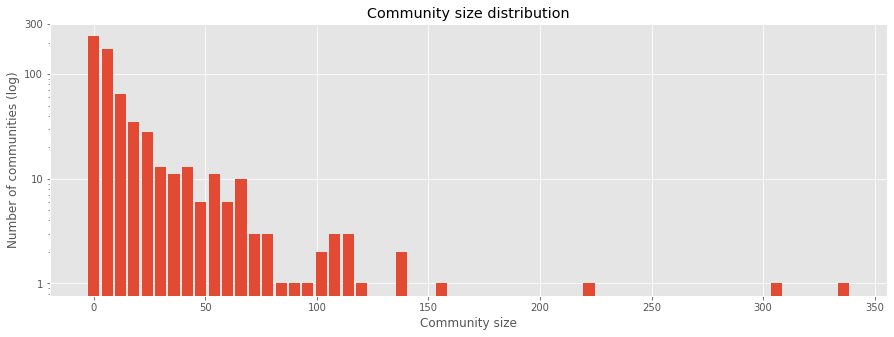

In [70]:
# Plotting histogram of communities

xs, ys = zip(*[(left, count) for left, _, count in posvertex.size_histogram(bin_width=6).bins()])
plt.bar(xs, ys, width=5,log=1)
plt.xlabel("Community size")
plt.ylabel("Number of communities (log)")
plt.title("Community size distribution")
plt.yticks([1,10,100,300], labels=[1,10,100,300])
plt.xticks(list(range(0,400,50)), labels=list(range(0,400,50)))
plt.savefig("communitySizeDistribution.png")
plt.show()

# Link Prediction
The following is our implementation of link prediction. We start by splitting the data into a train set and test set. These cannot be too big, since the algorithms are quite expensive computationally. We are also implementing our network as an undirected network instead of a directed one, due to networkx requiring undirected graphs to do link prediction.  

Whenever we're doing sets of edges, we duplicate all entries such that we both get (a,b) and (b,a). This is because they are not equal. The larger sets do not impact the performance though, since everything is almost doubled. 

Link prediction is done with 4 different algorithms: common neighbor, jaccard coefficient, preferential attachment and resource allocation index. 

Preferential attachment usually performs the best, but depending on the choice of hyperparameters, performance may differ. Sometimes, common neighbor or resource allocation index performs better. Overall, the performance was decent, not particularly great, but considering the circumstances of the training process, it's better than expected. 

A big issue is our training size. With 10000 edges used, we end up with 4089 nodes, 6915 edges and an average degree 3.38. That's a node-edge ratio of $\frac{6916}{4089}=1.69$ compared to the entire network with $\frac{135707}{35699}=3.8$. Essentially, this means that the training network has significantly less edges per node to work with, and it likely results in some of the core community structure of the Reddit network is lost. Improving the node-edge ratio would likely result in better performance, and this can only be done by increasing the size of the training set. 

In [ ]:
# create train and test dataset from reddit.tsv
# it's sorted such that edges appear according to timestamp
G_reddit = pd.read_csv(r'reddit.tsv', delimiter="\t")
G_reddit = G_reddit.sort_values('TIMESTAMP')
G_reddit = G_reddit.drop(labels=["POST_ID","TIMESTAMP","PROPERTIES"], axis=1)
train = G_reddit.iloc[:10000]
test  = G_reddit.iloc[10000:20000]
train.to_csv('train.csv')
test.to_csv('test.csv')

In [ ]:
# load train and test data, conver them to graphs and create test set from test data
test = pd.read_csv('test.csv')#.iloc[:1000]
train = pd.read_csv('train.csv')#.iloc[1000:2000]
G_train = nx.convert_matrix.from_pandas_edgelist(train, source="SOURCE_SUBREDDIT", target="TARGET_SUBREDDIT")
G_test = nx.convert_matrix.from_pandas_edgelist(test, source="SOURCE_SUBREDDIT", target="TARGET_SUBREDDIT")

In [ ]:
# create test set, remove all edges from the test set that contain nodes that are not in the training network
test_set1 = set(G_test.edges)
test_set2 = set([(pair[1], pair[0]) for pair in test_set1])
test_data = test_set1 | test_set2

nodes = set()
for pair in G_train.edges:
    nodes.add(pair[0])
    nodes.add(pair[1])

test_set = set()
for pair in test_data:
    if pair[0] in nodes and pair[1] in nodes:
        test_set.add(pair)

In [ ]:
# general function for link prediction, G is network, num_of_guesses is number of guesses 
# and method is the link prediction algorithm it uses. It's implemented using networkx functions.
def link_prediction(G, num_of_guesses, method):
    # find all combinations of unconnected pairs of nodes
    all_node_pairs = set(itertools.product(G.nodes, repeat = 2))
    all_unconnected_node_pairs = all_node_pairs - set(G.edges)
    
    # check which method is used, apply according function
    if method == "CN":
        score = {}
        for node_pair in all_unconnected_node_pairs:
            score[node_pair] = len(set(G.neighbors(node_pair[0])) & set(G.neighbors(node_pair[1])))
    elif method == "random_guess":
        sorted_best_guesses = set(random.sample(all_unconnected_node_pairs, num_of_guesses))
        guesses = set([guess for guess in sorted_best_guesses])
        reverse = set([(guess[1],guess[0]) for guess in sorted_best_guesses])
        return guesses | reverse
    elif method == "jaccard":
        all_unconnected_node_pairs = list(nx.jaccard_coefficient(G, ebunch=all_unconnected_node_pairs))
    elif method == "pa":
        all_unconnected_node_pairs = list(nx.preferential_attachment(G, ebunch=all_unconnected_node_pairs))
    elif method == "rai":
        all_unconnected_node_pairs = list(nx.resource_allocation_index(G, ebunch=all_unconnected_node_pairs))
    
    # assign node pairs as keys to dict with score as value
    if method != 'CN':
        score = {}
        for node_pair in all_unconnected_node_pairs:
            if node_pair[0] != node_pair[1]:  # check if self link
                score[(node_pair[0],node_pair[1])] = node_pair[2]

    # sort predictions according to largest score
    sorted_guesses = sorted(score.items(), key = lambda x: x[1], reverse = True)
    sorted_best_guesses = sorted_guesses[:num_of_guesses]
    # add all edges for both directions ((a,b) and (b,a)
    guesses = set([guess[0] for guess in sorted_best_guesses])
    reverse = set([(guess[0][1],guess[0][0]) for guess in sorted_best_guesses])
    return guesses | reverse

In [ ]:
# score performance of model using precision and recall
def score(G, test_set, method, num_of_guesses):
    guesses = link_prediction(G, num_of_guesses, method)
    precision = len(guesses & test_set) / len(guesses)
    recall = len(guesses & test_set) / len(test_set)
    return (precision, recall)

In [ ]:
# apply link prediction
funcs = ["CN", "jaccard", "pa", "rai", "random_guess"]
func_labels = ['common neighbor', 'jaccard', 'preferential attachment', 'resource allocation index', 'random guess']
for label,func in zip(func_labels, funcs):
    print(label, score(G_train, test_set, func, 100))